In [1]:
import json
import os

from pdf2image import convert_from_path
from easydict import EasyDict as edict
import matplotlib.pyplot as plt
from easyocr import Reader
from bardapi import Bard
import numpy as np
import cv2

![Python](https://img.shields.io/badge/python-3670A0?style=for-the-badge&logo=python&logoColor=ffdd54)
![OpenCV](https://img.shields.io/badge/opencv-%23white.svg?style=for-the-badge&logo=opencv&logoColor=white)
![NumPy](https://img.shields.io/badge/numpy-%23013243.svg?style=for-the-badge&logo=numpy&logoColor=white)
![Matplotlib](https://img.shields.io/badge/Matplotlib-%23ffffff.svg?style=for-the-badge&logo=Matplotlib&logoColor=black)
![Jupyter Notebook](https://img.shields.io/badge/jupyter-%23FA0F00.svg?style=for-the-badge&logo=jupyter&logoColor=white)
![BardAPI](https://img.shields.io/badge/pypi-BardAPI-black)

In [2]:
ROOT_PATH   = '/'.join(os.getcwd().split(os.path.sep)[:-2])
CONFIG_PATH = f'{ROOT_PATH}/utils/config.json'
CONFIG      = edict(json.loads(open(CONFIG_PATH, 'r').read()))

os.environ['_BARD_API_KEY'] = CONFIG.bard_key

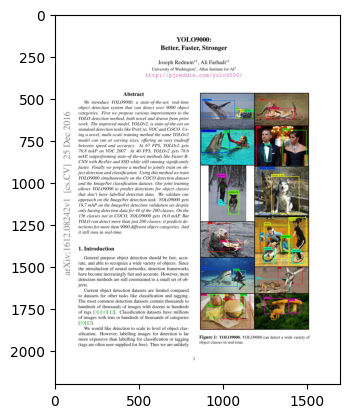

In [3]:
pages  = convert_from_path('yolov2.pdf', fmt = 'jpg')
reader = Reader(lang_list = ['en'], gpu = True) 
plt.imshow(pages[0])

In [4]:
## 페이지에 있는 figure나 table을 가려주는 함수 
## figure나 table에 글자가 있는 경우에 OCR이 읽어 문장이 이상해지는 경우가 있어 만듦.
def get_masked_page(image, need_rect = False):
    
    image    = np.array(image)
    image_cp = image.copy()
    
    gray     = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, bin_  = cv2.threshold(gray, 210, 255, cv2.THRESH_BINARY)
    
    H, W     = image.shape[:2]
    conts, _ = cv2.findContours(bin_, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    areas    = [cv2.contourArea(cont) for cont in conts]
    conts    = [(area, cont) for area, cont in zip(areas, conts) 
                    if 1000 < area < H * W - 5000]
    
    if len(conts) != 0:
        conts = sorted(conts, key = lambda x: x[0], reverse = True)
        for cont in conts:
            x, y, w, h = cv2.boundingRect(cont[1])
            cv2.rectangle(image_cp, (x, y), (x + w, y + h), (0, 255, 0), 15)

            figure     = gray[y: y + h, x - 10: x + (w + 10)]
            cv2.rectangle(gray, (x - 10, y), (x + (w + 10), y + h), (0, 0, 0), -1)
    
    if need_rect: 
        assert len(conts)!= 0, '해당 페이지에서는 figure 혹은 table을 찾을 수 없었습니다.'
        return gray, figure, image_cp
    
    return gray


## OCR을 이용하여 이미지에 있는 글자들을 읽어주는 함수
def read_text(image):
    
    results = reader.readtext(image)
    texts   = ' '.join([text[1] for text in results if len(text[1]) != 1])
    
    return texts


## Daniel Park 님께서 만들어주신 BardAPI를 통해 번역해주는 함수 
## https://github.com/dsdanielpark/Bard-API (GOAT)
def translate(prompt):
    
    prompt = f'다음 문장 한국어로 번역 해줘 {prompt}'  
    return Bard(timeout = 15).get_answer(prompt)

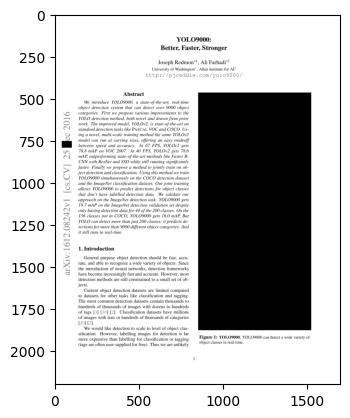

In [5]:
image, figure, rect = get_masked_page(pages[0], True)
plt.imshow(image, cmap = 'gray')

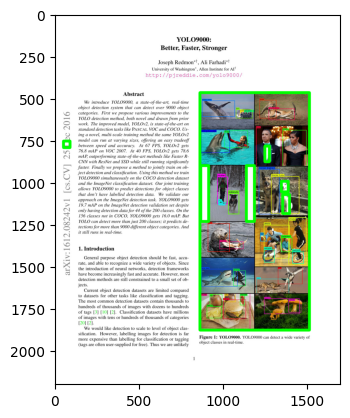

In [6]:
plt.imshow(rect)

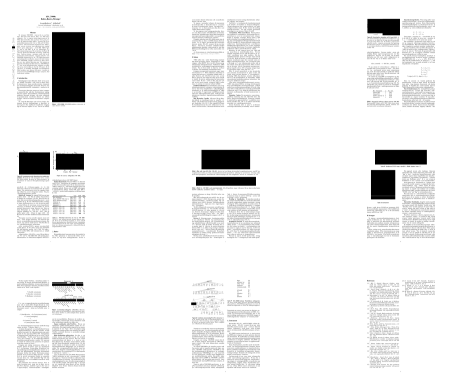

In [7]:
_, ax     = plt.subplots(3, 3)
pages     = [pages[idx: idx + 3] for idx in range(0, len(pages), 3)]

for odx, page in enumerate(pages):

    for idx, p in enumerate(page):

        try:
            image_, figure, rect = get_masked_page(p, True)

        except:
            image_ = get_masked_page(p)
        
        ax[odx][idx].imshow(image_, cmap = 'gray')
        ax[odx][idx].axis(False)
        

In [8]:
text   = read_text(image)
result = translate(text)['content']
result

'YOLO9000: Better; Faster; Stronger\n\nJoseph Redmon\nAli Farhadi*\nUniversity of Washington\nAllen Institute for AI\n\nhttp://pjreddie.com/yolo9000/\n\n요약\n\n우리는 YOLO9000을 소개합니다. YOLO9000은 실시간으로 9,000개 이상의 개체 카테고리를 인식할 수 있는 최첨단 시스템입니다. 먼저 YOLO 탐지 방법에 대한 다양한 개선 사항을 제안합니다. 이 개선된 모델인 YOLOv2는 PASCAL VOC 및 COCO와 같은 표준 탐지 작업에서 최첨단입니다. 새로운 다중 스케일 훈련 방법을 사용하면 동일한 YOLOv2 모델을 다양한 크기로 실행할 수 있습니다. 이는 속도와 정확성 사이에서 간단한 절충안을 제공합니다. 67 FPS에서 YOLOv2는 VOC 2007에서 76.8 mAP를 얻습니다. 40 FPS에서 YOLOv2는 78.6 mAP를 얻습니다. 이는 Faster R-CNN with ResNet 및 SSD와 같은 최첨단 방법을 능가하면서도 여전히 크게 빠릅니다. 마지막으로 객체 탐지 및 분류를 함께 훈련하는 방법을 제안합니다. 이 방법을 통해 YOLO9000을 COCO 탐지 데이터 세트와 ImageNet 분류 데이터 세트에서 동시에 훈련합니다. 우리의 훈련은 YOLO9000이 레이블이 지정된 탐지 데이터가 없는 개체 클래스에 대한 탐지를 예측할 수 있도록 합니다. 우리는 ImageNet 탐지 작업에서 접근 방식을 검증했습니다. YOLO9000은 44개 중 200개 클래스에 대한 탐지 데이터만 있음에도 불구하고 ImageNet 탐지 검증 세트에서 19.7 mAP를 얻습니다. COCO에 없는 156개 클래스에서 YOLO9000은 16.0 mAP를 얻습니다. 그러나 YOLO는 200개 클래스 이상을 감지할 수 있습니다. 실시간으로 9,000개 이상의 다양한 개체 범주에 대한 탐지를 예측합니다.\n\n1. 소개\n\n일반 목적의 객체

In [9]:
for res in result.split('\n\n'):
    print(res)

YOLO9000: Better; Faster; Stronger
Joseph Redmon
Ali Farhadi*
University of Washington
Allen Institute for AI
http://pjreddie.com/yolo9000/
요약
우리는 YOLO9000을 소개합니다. YOLO9000은 실시간으로 9,000개 이상의 개체 카테고리를 인식할 수 있는 최첨단 시스템입니다. 먼저 YOLO 탐지 방법에 대한 다양한 개선 사항을 제안합니다. 이 개선된 모델인 YOLOv2는 PASCAL VOC 및 COCO와 같은 표준 탐지 작업에서 최첨단입니다. 새로운 다중 스케일 훈련 방법을 사용하면 동일한 YOLOv2 모델을 다양한 크기로 실행할 수 있습니다. 이는 속도와 정확성 사이에서 간단한 절충안을 제공합니다. 67 FPS에서 YOLOv2는 VOC 2007에서 76.8 mAP를 얻습니다. 40 FPS에서 YOLOv2는 78.6 mAP를 얻습니다. 이는 Faster R-CNN with ResNet 및 SSD와 같은 최첨단 방법을 능가하면서도 여전히 크게 빠릅니다. 마지막으로 객체 탐지 및 분류를 함께 훈련하는 방법을 제안합니다. 이 방법을 통해 YOLO9000을 COCO 탐지 데이터 세트와 ImageNet 분류 데이터 세트에서 동시에 훈련합니다. 우리의 훈련은 YOLO9000이 레이블이 지정된 탐지 데이터가 없는 개체 클래스에 대한 탐지를 예측할 수 있도록 합니다. 우리는 ImageNet 탐지 작업에서 접근 방식을 검증했습니다. YOLO9000은 44개 중 200개 클래스에 대한 탐지 데이터만 있음에도 불구하고 ImageNet 탐지 검증 세트에서 19.7 mAP를 얻습니다. COCO에 없는 156개 클래스에서 YOLO9000은 16.0 mAP를 얻습니다. 그러나 YOLO는 200개 클래스 이상을 감지할 수 있습니다. 실시간으로 9,000개 이상의 다양한 개체 범주에 대한 탐지를 예측합니다.
1. 소개
일반 목적의 객체 탐지는 빠르고 정확하며 다양한 개체를 